# Sections

Frameworks:

* PyTorch first pass
    * `Model` with `forward` method.
    * Manual training loop
* PyTorch second pass
    * `Model` with `forward` method.
    * `Trainer` class that takes in:
        * `Model`
        * `Optimizer`
        * `_Loss`

Models:

* Boston dataset (used for testing)
* MNIST Conv net
* LSTM layer

In [1]:
# imports
from typing import Tuple, List
from collections import deque

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

import numpy as np
from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

from lincoln.utils import permute_data, assert_dim

from lincoln.pytorch.model import PyTorchModel
from lincoln.pytorch.train import PyTorchTrainer
from lincoln.pytorch.preprocessor import ConvNetPreprocessor

torch.manual_seed(20190325);

In [2]:
%load_ext autoreload
%autoreload 2

## `Trainer` class

# Boston dataset

In [3]:
from sklearn.datasets import load_boston

boston = load_boston()

data = boston.data
target = boston.target
features = boston.feature_names

from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

### Defining Boston model

In [4]:
class PyTorchLayer(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        raise NotImplementedError()
        
def inference_mode(m: nn.Module):
    m.eval()


In [5]:
class DenseLayer(PyTorchLayer):
    def __init__(self,
                 input_size: int,
                 neurons: int,
                 dropout: float = 1.0,
                 activation: nn.Module = None) -> None:
        super().__init__()
        self.linear = nn.Linear(input_size, neurons)
        self.activation = activation
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)


    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        if inference:
            self.apply(inference_mode)
        
        x = self.linear(x) # does weight multiplication + bias
        if self.activation:
            x = self.activation(x)
        if hasattr(self, "dropout"):
            x = self.dropout(x)
            
        return x

In [6]:
class BostonModel(PyTorchModel):

    def __init__(self,
                 hidden_size: int = 13,
                 hidden_dropout: float = 1.0):
        super().__init__()
        self.dense1 = DenseLayer(13, hidden_size, 
                                 activation=nn.Tanh(),
                                 dropout = hidden_dropout)
        self.dense2 = DenseLayer(hidden_size, 1)

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        
        assert_dim(x, 2)
        
        assert x.shape[1] == 13

        x = self.dense1(x, inference)
        return self.dense2(x, inference),

### Learning Rate Decay

In [7]:
# model, optimizer, loss
pytorch_boston_model = BostonModel(hidden_size=13, hidden_dropout=0.8)
optimizer = optim.SGD(pytorch_boston_model.parameters(), lr=0.001, momentum=0.9)

In [8]:
criterion = nn.MSELoss()

In [9]:
trainer = PyTorchTrainer(pytorch_boston_model, optimizer, criterion)

trainer.fit(X_train, y_train, X_test, y_test,
            epochs=100,
            eval_every=10,
            final_lr_exp = 0.001)

The loss after 0 epochs was 437.0794982910156
The loss after 10 epochs was 25.685544967651367
The loss after 20 epochs was 21.339204788208008
The loss after 30 epochs was 19.30413055419922
The loss after 40 epochs was 19.5618839263916
The loss after 50 epochs was 18.17092514038086
The loss after 60 epochs was 18.57846450805664
The loss after 70 epochs was 18.508407592773438
The loss after 80 epochs was 16.80544662475586
The loss after 90 epochs was 16.327821731567383


In [10]:
torch.mean(torch.pow(pytorch_boston_model(X_test, inference=True)[0] - y_test, 2)).item()

15.740818977355957

In [11]:
test_pred = pytorch_boston_model(X_test)[0].view(-1)
test_actual = y_test

In [12]:
test_pred = test_pred.detach().numpy()
test_actual = test_actual.detach().numpy()

## Boston - EDA

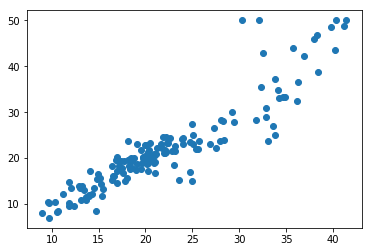

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(test_pred, test_actual)

# CNNs using PyTorch

We first show an example using `DataLoader`s, and then show one without using `DataLoader`s.

In [51]:
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1305,), (0.3081,))
])

In [52]:
# https://pytorch.org/docs/stable/data.html
train_dataset = MNIST(root='../mnist_data/',
                      train=True, 
                      download=True,
                      transform=img_transforms)

test_dataset = MNIST(root='../mnist_data/',
                     train=False, 
                     download=True,
                     transform=img_transforms)

In [53]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=60, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=60, 
                                           shuffle=False)

In [54]:
class ConvLayer(PyTorchLayer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int,
                 activation: nn.Module = None,
                 dropout: float = 1.0,
                 flatten: bool = False) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, filter_size, 
                              padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor) -> Tensor:

        x = self.conv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        if hasattr(self, "dropout"):
            x = self.dropout(x)            
            
        return x

In [55]:
class MNIST_ConvNet(PyTorchModel):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvLayer(1, 14, 5, activation=nn.Tanh(),
                               dropout=0.8)
        self.conv2 = ConvLayer(14, 7, 5, activation=nn.Tanh(), flatten=True,
                               dropout=0.8)
        self.dense1 = DenseLayer(28 * 28 * 7, 32, activation=nn.Tanh(),
                                 dropout=0.8)
        self.dense2 = DenseLayer(32, 10)

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 4)
            
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.dense1(x)
        x = self.dense2(x)
        return x,

In [56]:
model = MNIST_ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### Testing using only `Dataloader`

In [57]:
trainer = PyTorchTrainer(model, optimizer, criterion)

trainer.fit(train_dataloader = train_loader,        
            test_dataloader = test_loader,
            epochs=1,
            eval_every=1)

The loss after 0 epochs was 0.085


#### Accuracy using only the `DataLoader`

In [58]:
def test_accuracy(model):
    model.eval()
    accuracies = []
    for ii, (X_batch, y_batch) in enumerate(test_loader):
        output = model(X_batch)[0]
        accuracy_batch = (torch.max(output, dim=1)[1] == y_batch).type(torch.float32).mean().item()
        accuracies.append(accuracy_batch)
    return torch.Tensor(accuracies).mean()

In [59]:
test_accuracy(model)

tensor(0.9658)

### Without using `DataLoader`

#### Preprocessing

In [71]:
mnist_train = ((train_dataset.train_data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081
mnist_test = ((test_dataset.test_data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081

In [74]:
mnist_train.min(), mnist_train.max(), mnist_test.min(), mnist_test.max()

(tensor(-0.4236), tensor(2.8221), tensor(-0.4236), tensor(2.8221))

#### Training

In [73]:
trainer = PyTorchTrainer(model, optimizer, criterion)

trainer.fit(X_train=mnist_train, y_train=train_dataset.train_labels, 
            X_test=mnist_test, y_test=test_dataset.test_labels,     
            epochs=1,
            eval_every=1)

The loss after 0 epochs was 0.11979854851961136


#### Evaluating

In [76]:
def test_accuracy_no_dataloader(model, mnist_test):
    model.eval()
    output = model(mnist_test)[0]
    return (torch.max(output, dim=1)[1] == test_dataset.test_labels).type(torch.float32).mean().item()

In [78]:
test_accuracy_no_dataloader(model, mnist_test)

0.9659000039100647

~98% accuracy

## LSTM

Working backwards:

* Want a character level model - predict next char.

How to do it?

Pass in sequences. 

### New classes: `NextCharacterModel` and `LSTMTrainer`

* 5 = seq_len
* 3 = batch
* 10 = input_size
* 20 = hidden_size

* h0 = `(num_layers, batch_size, hidden_size)` = (2, 3, 20)

nn.LSTM(input_size, hidden_size, num_layers)

In [ ]:
class LSTMLayer(PyTorchLayer):
    def __init__(self,
                 sequence_length: int,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 dropout: float = 1.0) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.h_init = torch.zeros((1, hidden_size))
        self.c_init = torch.zeros((1, hidden_size))
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = DenseLayer(hidden_size, output_size)
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

        
    def _transform_hidden_batch(self, hidden: Tensor,
                                batch_size: int,
                                before_layer: bool) -> Tensor:
        
        if before_layer:
            return (hidden
                    .repeat(batch_size, 1)
                    .view(batch_size, 1, self.hidden_size)
                    .permute(1,0,2))
        else:
            return (hidden
                    .permute(1,0,2)
                    .mean(dim=0))         
    

    def forward(self, x: Tensor) -> Tensor:
        
        batch_size = x.shape[0]

        h_layer = self._transform_hidden_batch(self.h_init, batch_size, before_layer=True)
        c_layer = self._transform_hidden_batch(self.c_init, batch_size, before_layer=True)
        
        x, (h_out, c_out) = self.lstm(x, (h_layer, c_layer))
        
        self.h_init, self.c_init = (
            self._transform_hidden_batch(h_out, batch_size, before_layer=False).detach(),
            self._transform_hidden_batch(c_out, batch_size, before_layer=False).detach()
        )

        x = self.fc(x)
        if hasattr(self, "dropout"):
            x = self.dropout(x) 
            
        return x

In [ ]:
lay = LSTMLayer(sequence_length=25,
          input_size=62,
          hidden_size=100,
          output_size=128)

x = torch.randn(32, 25, 62)

In [ ]:
class NextCharacterModel(PyTorchModel):
    def __init__(self,
                 vocab_size: int,
                 hidden_size: int = 256,
                 sequence_length: int = 25):
        super().__init__()
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        
        # In this model, we have only one layer, with the same output size as input_size
        self.lstm = LSTMLayer(self.sequence_length, self.vocab_size, hidden_size, self.vocab_size)

    def forward(self,
                inputs: Tensor):
        assert_dim(inputs, 3) # batch_size, sequence_length, vocab_size

        out = self.lstm(inputs)       
        
        return out.permute(0, 2, 1),

In [ ]:
class LSTMTrainer(PyTorchTrainer):
    def __init__(self,
                 model: NextCharacterModel,
                 optim: Optimizer,
                 criterion: _Loss):
        super().__init__(model, optim, criterion)
        self.vocab_size = self.model.vocab_size
        self.max_len = self.model.sequence_length
        
    def fit(self,
            data: str,
            epochs: int=10,
            eval_every: int=1,
            batch_size: int=32,
            seed: int = 121718)-> None:
        
        self.data = data
        self.train_data, self.test_data = self._train_test_split_text()
        self.chars = list(set(self.data))
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}

        torch.manual_seed(seed)

        losses = deque(maxlen=50)
        
        for e in range(epochs):

            batch_generator = self.generate_batches_next_char(batch_size)

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                self.optim.zero_grad()                
                outputs = self.model(X_batch)

                loss = self.loss(outputs, y_batch)
                losses.append(loss.item())

                loss.backward()
                print(loss.item())
                
                self.optim.step()    

            if (e+1) % eval_every == 0:

                X_test, y_test = self.generate_test_data()
            
                test_preds = self.net.forward(X_test)
                loss = self.net.loss.forward(test_preds, y_test)
                print(f"Validation loss after {e+1} epochs is {loss:.3f}")

    def _train_test_split_text(self, pct=0.8) -> Tuple[str]:

        n = len(self.data)
        return self.data[:int(n * pct)], self.data[int(n * pct):]

    def generate_batches_next_char(self,
                                   batch_size: int) -> Tuple[Tensor]:
        N = len(self.train_data)
        # add batch size
        for ii in range(0, N, batch_size):

            features_tensors = []
            target_indices = []

            for char in range(batch_size):

                features_str, target_str =\
                 self.train_data[ii+char:ii+char+self.max_len],\
                 self.train_data[ii+char+1:ii+char+self.max_len+1]

                features_array = self._string_to_one_hot_array(features_str)
                target_indices_seq = [self.char_to_idx[char] for char in target_str]

                features_tensors.append(features_array)
                target_indices.append(target_indices_seq)
#             import pdb; pdb.set_trace()
            yield torch.stack(features_tensors), torch.LongTensor(target_indices)

    def _string_to_one_hot_array(self, input_string: str) -> Tuple[Tensor]:

        ind = [self.char_to_idx[ch] for ch in input_string]

        array = self._one_hot_text_data(ind)

        return array

    def _one_hot_text_data(self,
                           sequence: List):

        sequence_length = len(sequence)
        batch = torch.zeros(sequence_length, self.vocab_size)
        for i in range(sequence_length):
            batch[i, sequence[i]] = 1.0

        return Tensor(batch)

    def generate_test_data(self) -> Tuple[Tensor]:

        features_str, target_str = self.test_data[:-1], self.test_data[1:]

        X_tensors = []
        y_tensors = []

        N = len(self.test_data)

        for start in range(0, N, self.max_len):

            features_str, target_str =\
             self.test_data[start:start+self.max_len],\
             self.test_data[start+1:start+self.max_len+1]

            features_array, target_array =\
                self._string_to_one_hot_array(features_str),\
                self._string_to_one_hot_array(target_str)

            X_tensors.append(features_array)
            y_tensors.append(target_array)

        return torch.stack(X_tensors), torch.stack(y_tensors)


In [ ]:
data = open('data/input.txt', 'r').read()
vocab_size = len(set(data))
model = NextCharacterModel(vocab_size, hidden_size=vocab_size, sequence_length=50)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                             weight_decay=1e-5)

In [ ]:
lstm_trainer = LSTMTrainer(model, optimizer, criterion)

In [ ]:
# lstm_trainer.fit(data)

TODO:

* Write code to generate next character from this.
* Write early stopping code.

## Unsupervised Learning with Autoencoder

In [ ]:
class DeconvLayer(PyTorchLayer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int,
                 activation: nn.Module = None,
                 dropout: float = 1.0,
                 flatten: bool = False) -> None:
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, filter_size, 
                                       padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor) -> Tensor:

        x = self.deconv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        if hasattr(self, "dropout"):
            x = self.dropout(x)            
            
        return x

In [79]:
class Autoencoder(PyTorchModel):
    def __init__(self,
                 hidden_dim: int = 28):
        super(Autoencoder, self).__init__()
        self.conv1 = ConvLayer(1, 14, 5, activation=nn.Tanh())
        self.conv2 = ConvLayer(14, 7, 5, activation=nn.Tanh(), flatten=True)
        
        self.dense1 = DenseLayer(7 * 28 * 28, hidden_dim, activation=nn.Tanh())
        self.dense2 = DenseLayer(hidden_dim, 7 * 28 * 28, activation=nn.Tanh())
        
        self.conv3 = ConvLayer(7, 14, 5, activation=nn.Tanh()) 
        self.conv4 = ConvLayer(14, 1, 5, activation=nn.Tanh())         

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 4)
            
        x = self.conv1(x)
        x = self.conv2(x)
#         import pdb; pdb.set_trace()
        encoding = self.dense1(x)
        
        x = self.dense2(encoding)
        
        x = x.view(-1, 7, 28, 28)
        
        x = self.conv3(x)
        x = self.conv4(x)

        return x, encoding

### Preprocess data

In [82]:
X_train = mnist_train
X_test = mnist_test

In [83]:
X_train_auto = (X_train - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1
X_test_auto = (X_test - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1

In [85]:
model = Autoencoder()

In [96]:
model = Autoencoder(hidden_dim=28)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

trainer = PyTorchTrainer(model, optimizer, criterion)

trainer.fit(X_train_auto, X_train_auto,
            X_test_auto, X_test_auto,
            epochs=1,
            batch_size=60)

The loss after 0 epochs was 0.0699353963136673


In [97]:
reconstructed_images, image_representations = model(X_test_auto)

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [99]:
def display_image(ax,
    t: Tensor):
    n = t.detach().numpy()
    ax.imshow(n.reshape(28, 28))

In [100]:
np.random.seed(20190504)
a = np.random.randint(0, 10000)

In [101]:
X_test[a].shape

torch.Size([1, 28, 28])

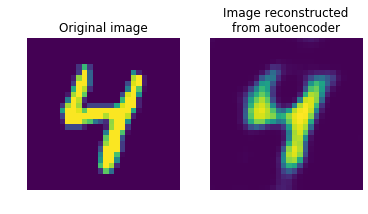

In [102]:
f, axarr = plt.subplots(1,2)
display_image(axarr[0], X_test[a])
display_image(axarr[1], reconstructed_images[a])

axarr[0].set_title("Original image")
axarr[1].set_title("Image reconstructed\nfrom autoencoder")

axarr[0].axis('off')
axarr[1].axis('off');

f.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/03_autoencoder_example_image.png")

## TSNE on the results

In [ ]:
from sklearn.manifold import TSNE
tsne_result = TSNE(n_components=2, random_state=20190405).fit_transform(out[1].detach().numpy())

#### TSNE viz

In [ ]:
import pandas as pd
tsne_df = pd.DataFrame({'tsne_dim_1': tsne_result[:,0], 
              'tsne_dim_2': tsne_result[:,1],
              'category': mnist_testset.test_labels})

# tsne_df.plot.scatter(x='tsne_dim_1', y='tsne_dim_2')

# Plot
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title('''10000 observations from MNIST test set, colored by their actual digit. 
Locations are the result of reducing the 28 values from hidden layer of the convolutional
autoencoder - trained without labels - down to two dimensions using t-SNE.''')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.scatter(group['tsne_dim_1'], group['tsne_dim_2'], marker='o', label=name)
ax.legend()
# fig.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/00_tsne.png")

## Autoencoder with hidden dimension 2

Just out of curiosity

In [ ]:
model2 = Autoencoder2(hidden_dim=2)
criterion = nn.MSELoss()
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

trainer = PyTorchTrainer(model2, optimizer, criterion)

trainer.fit(X_train_auto, X_train_auto, 
            X_test_auto, X_test_auto,
            epochs=1,
            eval_every=1,
            batch_size=60,
            final_lr_exp = 0.001)

In [ ]:
reconstructed_images, image_representations = model2(X_test_auto)

In [ ]:
f, axarr = plt.subplots(1,2)
display_image(axarr[0], X_test[3765])
display_image(axarr[1], reconstructed_images[3765])

axarr[0].set_title("Original image")
axarr[1].set_title("Image reconstructed\nfrom autoencoder")

axarr[0].axis('off')
axarr[1].axis('off');

# f.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/03_autoencoder_example_image.png")